In [9]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics, utils
import pandas as pd
import seaborn as sns
import cv2
from PIL import Image
import os

In [11]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Train.csv")

train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Number of different Classes:  43


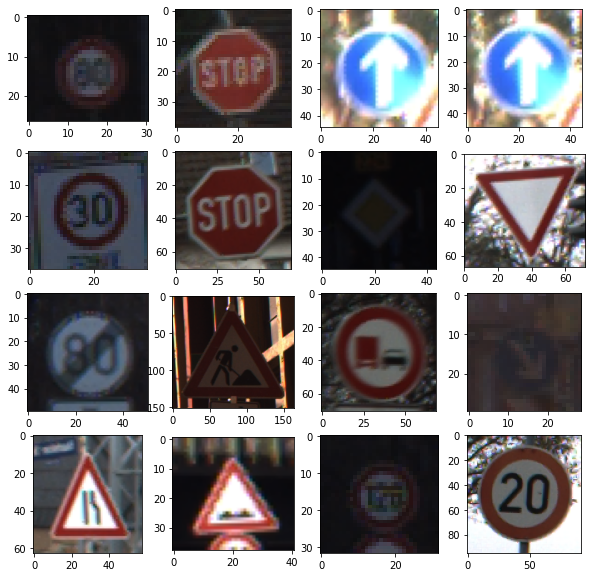

In [14]:
class_type = train_data['ClassId'].nunique()
print("Number of different Classes: ", class_type)

img_src = train_data["Path"]
num_rows = train_data['ClassId'].count()

sample = plt.subplots(4,4, figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    ind = np.random.randint(num_rows)
    plt.imshow(plt.imread(img_src[ind]))
#     plt.imshow(plt.imread(train_data["Path"][np.random.randint(num_rows)]))

plt.show()

In [15]:
train_data['ClassId']=train_data['ClassId'].astype('str')
train_data = pd.concat([train_data['Path'], train_data['ClassId']], axis = 1)
train_data = utils.shuffle(train_data)
train_data.head()


,Path,ClassId
34014,Train/34/00034_00007_00025.png,34
8206,Train/4/00004_00058_00016.png,4
23030,Train/14/00014_00013_00020.png,14
35437,Train/36/00036_00001_00008.png,36
3674,Train/2/00002_00029_00014.png,2
